### __Data Preprocessing & Prediction - Testing Dataset__

In [1]:
# import libraries
import numpy as np
import pandas as pd
import random
from datetime import datetime, timezone, timedelta
import datetime as dt
import time

# import matplotlib
from matplotlib import pyplot
import matplotlib.pyplot as plt

import statsmodels.api as sm

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
import sklearn.model_selection as model_selection
import sklearn.model_selection as cross_validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import average_precision_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_precision_recall_curve, plot_confusion_matrix
from sklearn.feature_selection import RFE
from sklearn import linear_model, datasets
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.svm import SVR
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
#from sklearn.externals.six import StringIO  
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import sklearn.gaussian_process as gp
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor

# to be able to see multiple ouputs from sungle cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

C:\Users\User\anaconda3\envs\jupyterlab-3.2.1\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


#### __Preprocessing Data Steps__
> - Step 1. Remove insignificant variables:
    - string variables: branded_code_share, mkt_carrier, tail_num, origin, origin_city_name, dest, dest_city_name, dup, flights
    - variables with high correlation: mkt_carrier_fl_num, op_carrier_fl_num, distance (highly correlated to crs_elapsed_time)
> - Step 2. Create additional features: 
    - year, month and day_of_week from 'fl_date'
    - hours from both, 'crs_dep_time' and 'crs_arr_time'
> - Step 3. Get features from passengers and fuel
    - from passengers_summary: speed, passengers_mean, and passengers_sum
    - from fuel_summary: total_cost mean and sum, and total_gallons mean and sum
> - Setp 4. Create dummy variables based on the following features:
    - year
    - month
    - day_of_week
    - mkt_unique_carrier & op_unique_carrier
    - origin_airport_id & dest_airport_id
    - two hours variables (from 'crs_dep_time' and 'crs_arr_time')

-------------------------------------------------

#### __Import Datasets__

In [2]:
# Import training csv file
df = pd.read_csv('../flights_test.csv')
df.info()
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660556 entries, 0 to 660555
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   fl_date             660556 non-null  object
 1   mkt_unique_carrier  660556 non-null  object
 2   branded_code_share  660556 non-null  object
 3   mkt_carrier         660556 non-null  object
 4   mkt_carrier_fl_num  660556 non-null  int64 
 5   op_unique_carrier   660556 non-null  object
 6   tail_num            659057 non-null  object
 7   op_carrier_fl_num   660556 non-null  int64 
 8   origin_airport_id   660556 non-null  int64 
 9   origin              660556 non-null  object
 10  origin_city_name    660556 non-null  object
 11  dest_airport_id     660556 non-null  int64 
 12  dest                660556 non-null  object
 13  dest_city_name      660556 non-null  object
 14  crs_dep_time        660556 non-null  int64 
 15  crs_arr_time        660556 non-null  int64 
 16  du

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,crs_arr_time,dup,crs_elapsed_time,flights,distance
0,2020-01-01,WN,WN,WN,5888,WN,N951WN,5888,13891,ONT,"Ontario, CA",14771,SFO,"San Francisco, CA",1810,1945,N,95,1,363
1,2020-01-01,WN,WN,WN,6276,WN,N467WN,6276,13891,ONT,"Ontario, CA",14771,SFO,"San Francisco, CA",1150,1320,N,90,1,363
2,2020-01-01,WN,WN,WN,4598,WN,N7885A,4598,13891,ONT,"Ontario, CA",14831,SJC,"San Jose, CA",2020,2130,N,70,1,333


-----------------------------------------

#### __Import Summary Files__
> - Passenger Summary
> - Fuel Summary
> - Averave Arrival Delay

In [3]:
passengers = pd.read_csv('../passengers_summary.csv')
passengers.info()
passengers.head()

fuel = pd.read_csv('../fuel_summary.csv')
fuel.info()
fuel.head()

avg_arr = pd.read_csv('../arr_delay_avg_jan_dec.csv')
avg_arr.info()
avg_arr.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139480 entries, 0 to 139479
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   item_id           139480 non-null  object 
 1   carrier_month_id  139480 non-null  object 
 2   dest_airport_id   139480 non-null  int64  
 3   unique_carrier    139480 non-null  object 
 4   month             139480 non-null  int64  
 5   air_time          139480 non-null  float64
 6   distance          139480 non-null  float64
 7   passengers        139480 non-null  float64
 8   speed             139480 non-null  float64
 9   mean_passengers   139480 non-null  float64
 10  sum_passengers    139480 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 11.7+ MB


,item_id,carrier_month_id,dest_airport_id,unique_carrier,month,air_time,distance,passengers,speed,mean_passengers,sum_passengers
0,100055V10,5V10,10005,5V,10,954.0,1325.0,16.0,1.388889,10.0,8580
1,100145V10,5V10,10014,5V,10,82.0,70.0,0.0,0.853659,10.0,8580
2,100645V10,5V10,10064,5V,10,30.0,224.0,0.0,7.466667,10.0,8580
3,101395V10,5V10,10139,5V,10,91.0,323.0,0.0,3.549451,10.0,8580
4,101845V10,5V10,10184,5V,10,274.0,546.0,17.0,1.992701,10.0,8580


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   carrier_month_id    756 non-null    object 
 1   carrier             756 non-null    object 
 2   month               756 non-null    int64  
 3   total_cost:mean     756 non-null    float64
 4   total_cost:sum      756 non-null    float64
 5   total_gallons:mean  756 non-null    float64
 6   total_gallons:sum   756 non-null    float64
dtypes: float64(4), int64(1), object(2)
memory usage: 41.5+ KB


,carrier_month_id,carrier,month,total_cost:mean,total_cost:sum,total_gallons:mean,total_gallons:sum
0,09Q1,09Q,1,2.878729e+06,8636187.0,1.018414e+06,3055241.0
1,09Q10,09Q,10,2.892003e+06,8676010.0,1.210001e+06,3630002.0
2,09Q11,09Q,11,2.627896e+06,7883689.0,1.006282e+06,3018846.0
3,09Q12,09Q,12,2.743162e+06,8229487.0,9.321290e+05,2796387.0
4,09Q2,09Q,2,2.266957e+06,9067827.0,8.760805e+05,3504322.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25968 entries, 0 to 25967
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   item_id    25968 non-null  object 
 1   arr_delay  25968 non-null  float64
dtypes: float64(1), object(1)
memory usage: 405.9+ KB


,item_id,arr_delay
0,9EABEATL1,7.073171
1,9EABEATL12,4.104762
2,9EABYATL1,12.512821
3,9EAEXATL1,-5.312195
4,9EAEXATL12,2.244344


-------------------------------------------

#### __Set Aside columns for creating the submission file later__

In [5]:
df_submission_col = df[['fl_date', 'mkt_carrier', 'mkt_carrier_fl_num', 'origin', 'dest']]

df_submission_col.info()
df_submission_col.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660556 entries, 0 to 660555
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   fl_date             660556 non-null  object
 1   mkt_carrier         660556 non-null  object
 2   mkt_carrier_fl_num  660556 non-null  int64 
 3   origin              660556 non-null  object
 4   dest                660556 non-null  object
dtypes: int64(1), object(4)
memory usage: 25.2+ MB


,fl_date,mkt_carrier,mkt_carrier_fl_num,origin,dest
0,2020-01-01,WN,5888,ONT,SFO
1,2020-01-01,WN,6276,ONT,SFO
2,2020-01-01,WN,4598,ONT,SJC
3,2020-01-01,WN,4761,ONT,SJC
4,2020-01-01,WN,5162,ONT,SJC


#### Step 1. Remove insignificant variables

In [6]:
# start time to measure the time of the program execution
start_time = time.time()

# drop columns
df = df.drop(columns=['branded_code_share', 'mkt_carrier', 
                      'origin_city_name', 'dest_city_name', 'dup', 
                      'origin_airport_id', 'tail_num',
                      'op_carrier_fl_num'
])

# rearrange columns
rearranged_columns = ['fl_date', 'dest_airport_id', 'mkt_unique_carrier', 'op_unique_carrier',
                      'mkt_carrier_fl_num', 'origin', 'dest', 'crs_dep_time', 'crs_arr_time', 
                      'crs_elapsed_time', 'flights', 'distance']

df = df[rearranged_columns]

# check
df.info()
df.head()

# print the overall program runtime.
print(f"\n\n--- {(time.time() - start_time)} seconds ---")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660556 entries, 0 to 660555
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   fl_date             660556 non-null  object
 1   dest_airport_id     660556 non-null  int64 
 2   mkt_unique_carrier  660556 non-null  object
 3   op_unique_carrier   660556 non-null  object
 4   mkt_carrier_fl_num  660556 non-null  int64 
 5   origin              660556 non-null  object
 6   dest                660556 non-null  object
 7   crs_dep_time        660556 non-null  int64 
 8   crs_arr_time        660556 non-null  int64 
 9   crs_elapsed_time    660556 non-null  int64 
 10  flights             660556 non-null  int64 
 11  distance            660556 non-null  int64 
dtypes: int64(7), object(5)
memory usage: 60.5+ MB


,fl_date,dest_airport_id,mkt_unique_carrier,op_unique_carrier,mkt_carrier_fl_num,origin,dest,crs_dep_time,crs_arr_time,crs_elapsed_time,flights,distance
0,2020-01-01,14771,WN,WN,5888,ONT,SFO,1810,1945,95,1,363
1,2020-01-01,14771,WN,WN,6276,ONT,SFO,1150,1320,90,1,363
2,2020-01-01,14831,WN,WN,4598,ONT,SJC,2020,2130,70,1,333
3,2020-01-01,14831,WN,WN,4761,ONT,SJC,1340,1455,75,1,333
4,2020-01-01,14831,WN,WN,5162,ONT,SJC,915,1035,80,1,333




--- 0.8365936279296875 seconds ---


#### Step 2. Create additional features

In [7]:
# start time to measure the time of the program execution
start_time = time.time()

# convert 'fl_date' to datetime ('2019-05-01')
df['fl_date'] = pd.to_datetime(df['fl_date'], format='%Y-%m-%d')

# compute year, month and weekdays from 'fl_date' in df
month_train = [x.month for x in df['fl_date']]
year_train = [x.year for x in df['fl_date']]
dayofweek_train = df['fl_date'].dt.dayofweek

# insert new columns in df
df.insert(loc=1, column='year', value=year_train)
df.insert(loc=2, column='month', value=month_train)
df.insert(loc=3, column='day_of_week', value=dayofweek_train)

# check
df.info()
df.head()

# print the overall program runtime.
print(f"\n\n--- {(time.time() - start_time)} seconds ---")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660556 entries, 0 to 660555
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   fl_date             660556 non-null  datetime64[ns]
 1   year                660556 non-null  int64         
 2   month               660556 non-null  int64         
 3   day_of_week         660556 non-null  int64         
 4   dest_airport_id     660556 non-null  int64         
 5   mkt_unique_carrier  660556 non-null  object        
 6   op_unique_carrier   660556 non-null  object        
 7   mkt_carrier_fl_num  660556 non-null  int64         
 8   origin              660556 non-null  object        
 9   dest                660556 non-null  object        
 10  crs_dep_time        660556 non-null  int64         
 11  crs_arr_time        660556 non-null  int64         
 12  crs_elapsed_time    660556 non-null  int64         
 13  flights             660556 no

,fl_date,year,month,day_of_week,dest_airport_id,mkt_unique_carrier,op_unique_carrier,mkt_carrier_fl_num,origin,dest,crs_dep_time,crs_arr_time,crs_elapsed_time,flights,distance
0,2020-01-01,2020,1,2,14771,WN,WN,5888,ONT,SFO,1810,1945,95,1,363
1,2020-01-01,2020,1,2,14771,WN,WN,6276,ONT,SFO,1150,1320,90,1,363
2,2020-01-01,2020,1,2,14831,WN,WN,4598,ONT,SJC,2020,2130,70,1,333
3,2020-01-01,2020,1,2,14831,WN,WN,4761,ONT,SJC,1340,1455,75,1,333
4,2020-01-01,2020,1,2,14831,WN,WN,5162,ONT,SJC,915,1035,80,1,333




--- 5.237790107727051 seconds ---


#### Step 3. Get features from passengers, fuel & avgerage arrival delay

In [8]:
# start time to measure the time of the program execution
start_time = time.time()

# create new id variable to merge with passenger_summary table
item_id = []

for num in range(len(df)):
    item = str(df.iloc[num, 4]) + df.iloc[num, 6] + str(df.iloc[num, 2])
    item_id.append(item)

df.insert(loc=0, column='item_id', value=item_id)

# check
df.info()
df.head()

# print the overall program runtime.
print(f"\n\n--- {(time.time() - start_time)} seconds ---")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660556 entries, 0 to 660555
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   item_id             660556 non-null  object        
 1   fl_date             660556 non-null  datetime64[ns]
 2   year                660556 non-null  int64         
 3   month               660556 non-null  int64         
 4   day_of_week         660556 non-null  int64         
 5   dest_airport_id     660556 non-null  int64         
 6   mkt_unique_carrier  660556 non-null  object        
 7   op_unique_carrier   660556 non-null  object        
 8   mkt_carrier_fl_num  660556 non-null  int64         
 9   origin              660556 non-null  object        
 10  dest                660556 non-null  object        
 11  crs_dep_time        660556 non-null  int64         
 12  crs_arr_time        660556 non-null  int64         
 13  crs_elapsed_time    660556 no

,item_id,fl_date,year,month,day_of_week,dest_airport_id,mkt_unique_carrier,op_unique_carrier,mkt_carrier_fl_num,origin,dest,crs_dep_time,crs_arr_time,crs_elapsed_time,flights,distance
0,14771WN1,2020-01-01,2020,1,2,14771,WN,WN,5888,ONT,SFO,1810,1945,95,1,363
1,14771WN1,2020-01-01,2020,1,2,14771,WN,WN,6276,ONT,SFO,1150,1320,90,1,363
2,14831WN1,2020-01-01,2020,1,2,14831,WN,WN,4598,ONT,SJC,2020,2130,70,1,333
3,14831WN1,2020-01-01,2020,1,2,14831,WN,WN,4761,ONT,SJC,1340,1455,75,1,333
4,14831WN1,2020-01-01,2020,1,2,14831,WN,WN,5162,ONT,SJC,915,1035,80,1,333




--- 106.09728980064392 seconds ---


In [9]:
# start time to measure the time of the program execution
start_time = time.time()

# remove columns from passenger_summary that should not be merged to df
pass_df = passengers.drop(columns=['carrier_month_id', 'dest_airport_id',
                                   'unique_carrier', 'month', 'air_time',
                                   'distance', 'passengers'])

# inner join sum_pass_df with carrier_pass
df = df.merge(pass_df, how='left', on='item_id')
df = df.rename({'speed': 'speed_passengers'}, axis=1)

# check
df.info()
df.head()

# print the overall program runtime.
print(f"\n\n--- {(time.time() - start_time)} seconds ---")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 660556 entries, 0 to 660555
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   item_id             660556 non-null  object        
 1   fl_date             660556 non-null  datetime64[ns]
 2   year                660556 non-null  int64         
 3   month               660556 non-null  int64         
 4   day_of_week         660556 non-null  int64         
 5   dest_airport_id     660556 non-null  int64         
 6   mkt_unique_carrier  660556 non-null  object        
 7   op_unique_carrier   660556 non-null  object        
 8   mkt_carrier_fl_num  660556 non-null  int64         
 9   origin              660556 non-null  object        
 10  dest                660556 non-null  object        
 11  crs_dep_time        660556 non-null  int64         
 12  crs_arr_time        660556 non-null  int64         
 13  crs_elapsed_time    660556 no

,item_id,fl_date,year,month,day_of_week,dest_airport_id,mkt_unique_carrier,op_unique_carrier,mkt_carrier_fl_num,origin,dest,crs_dep_time,crs_arr_time,crs_elapsed_time,flights,distance,speed_passengers,mean_passengers,sum_passengers
0,14771WN1,2020-01-01,2020,1,2,14771,WN,WN,5888,ONT,SFO,1810,1945,95,1,363,0.173843,1.0,15744.0
1,14771WN1,2020-01-01,2020,1,2,14771,WN,WN,6276,ONT,SFO,1150,1320,90,1,363,0.173843,1.0,15744.0
2,14831WN1,2020-01-01,2020,1,2,14831,WN,WN,4598,ONT,SJC,2020,2130,70,1,333,0.177136,1.0,15744.0
3,14831WN1,2020-01-01,2020,1,2,14831,WN,WN,4761,ONT,SJC,1340,1455,75,1,333,0.177136,1.0,15744.0
4,14831WN1,2020-01-01,2020,1,2,14831,WN,WN,5162,ONT,SJC,915,1035,80,1,333,0.177136,1.0,15744.0




--- 1.533769130706787 seconds ---


In [10]:
# start time to measure the time of the program execution
start_time = time.time()

# for three new columns merged from passenger_summary,
#  if there are any missing values, fill missing values with min values
df['speed_passengers'] = df['speed_passengers'].fillna(df['speed_passengers'].min())
df['mean_passengers'] = df['mean_passengers'].fillna(df['mean_passengers'].min())
df['sum_passengers'] = df['sum_passengers'].fillna(df['sum_passengers'].min())

# check
df.info()
df.head()

# print the overall program runtime.
print(f"\n\n--- {(time.time() - start_time)} seconds ---")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 660556 entries, 0 to 660555
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   item_id             660556 non-null  object        
 1   fl_date             660556 non-null  datetime64[ns]
 2   year                660556 non-null  int64         
 3   month               660556 non-null  int64         
 4   day_of_week         660556 non-null  int64         
 5   dest_airport_id     660556 non-null  int64         
 6   mkt_unique_carrier  660556 non-null  object        
 7   op_unique_carrier   660556 non-null  object        
 8   mkt_carrier_fl_num  660556 non-null  int64         
 9   origin              660556 non-null  object        
 10  dest                660556 non-null  object        
 11  crs_dep_time        660556 non-null  int64         
 12  crs_arr_time        660556 non-null  int64         
 13  crs_elapsed_time    660556 no

,item_id,fl_date,year,month,day_of_week,dest_airport_id,mkt_unique_carrier,op_unique_carrier,mkt_carrier_fl_num,origin,dest,crs_dep_time,crs_arr_time,crs_elapsed_time,flights,distance,speed_passengers,mean_passengers,sum_passengers
0,14771WN1,2020-01-01,2020,1,2,14771,WN,WN,5888,ONT,SFO,1810,1945,95,1,363,0.173843,1.0,15744.0
1,14771WN1,2020-01-01,2020,1,2,14771,WN,WN,6276,ONT,SFO,1150,1320,90,1,363,0.173843,1.0,15744.0
2,14831WN1,2020-01-01,2020,1,2,14831,WN,WN,4598,ONT,SJC,2020,2130,70,1,333,0.177136,1.0,15744.0
3,14831WN1,2020-01-01,2020,1,2,14831,WN,WN,4761,ONT,SJC,1340,1455,75,1,333,0.177136,1.0,15744.0
4,14831WN1,2020-01-01,2020,1,2,14831,WN,WN,5162,ONT,SJC,915,1035,80,1,333,0.177136,1.0,15744.0




--- 0.9121866226196289 seconds ---


In [11]:
# start time to measure the time of the program execution
start_time = time.time()

# create new id variable to merge with passenger_summary table
carrier_month_id = []

for num in range(len(df)):
    item = df.iloc[num, 7] + str(df.iloc[num, 3])
    carrier_month_id.append(item)

df.insert(loc=1, column='carrier_month_id', value=carrier_month_id)

# remove columns from fuel_summary that should not be merged to df
fuel_df = fuel.drop(columns=['carrier', 'month'])

# inner join sum_pass_df with carrier_pass
df = df.merge(fuel_df, how='left', on='carrier_month_id')
df = df.rename({'total_cost:mean': 'total_cost:mean_fuel',
               'total_cost:sum': 'total_cost:sum_fuel',
               'total_gallons:mean': 'total_gallons:mean_fuel',
               'total_gallons:sum': 'total_gallons:sum_fuel'}, axis=1)

# check
df.info()
df.head()

# print the overall program runtime.
print(f"\n\n--- {(time.time() - start_time)} seconds ---")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 660556 entries, 0 to 660555
Data columns (total 24 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   item_id                  660556 non-null  object        
 1   carrier_month_id         660556 non-null  object        
 2   fl_date                  660556 non-null  datetime64[ns]
 3   year                     660556 non-null  int64         
 4   month                    660556 non-null  int64         
 5   day_of_week              660556 non-null  int64         
 6   dest_airport_id          660556 non-null  int64         
 7   mkt_unique_carrier       660556 non-null  object        
 8   op_unique_carrier        660556 non-null  object        
 9   mkt_carrier_fl_num       660556 non-null  int64         
 10  origin                   660556 non-null  object        
 11  dest                     660556 non-null  object        
 12  crs_dep_time    

,item_id,carrier_month_id,fl_date,year,month,day_of_week,dest_airport_id,mkt_unique_carrier,op_unique_carrier,mkt_carrier_fl_num,...,crs_elapsed_time,flights,distance,speed_passengers,mean_passengers,sum_passengers,total_cost:mean_fuel,total_cost:sum_fuel,total_gallons:mean_fuel,total_gallons:sum_fuel
0,14771WN1,WN1,2020-01-01,2020,1,2,14771,WN,WN,5888,...,95,1,363,0.173843,1.0,15744.0,296682409.0,1.483412e+09,157934010.0,789670050.0
1,14771WN1,WN1,2020-01-01,2020,1,2,14771,WN,WN,6276,...,90,1,363,0.173843,1.0,15744.0,296682409.0,1.483412e+09,157934010.0,789670050.0
2,14831WN1,WN1,2020-01-01,2020,1,2,14831,WN,WN,4598,...,70,1,333,0.177136,1.0,15744.0,296682409.0,1.483412e+09,157934010.0,789670050.0
3,14831WN1,WN1,2020-01-01,2020,1,2,14831,WN,WN,4761,...,75,1,333,0.177136,1.0,15744.0,296682409.0,1.483412e+09,157934010.0,789670050.0
4,14831WN1,WN1,2020-01-01,2020,1,2,14831,WN,WN,5162,...,80,1,333,0.177136,1.0,15744.0,296682409.0,1.483412e+09,157934010.0,789670050.0




--- 76.2698655128479 seconds ---


In [12]:
# for four new columns merged from fuel_summary,
#  if there are any missing values, fill missing values with 0
df['total_cost:mean_fuel'] = df['total_cost:mean_fuel'].fillna(df['total_cost:mean_fuel'].min())
df['total_cost:sum_fuel'] = df['total_cost:sum_fuel'].fillna(df['total_cost:sum_fuel'].min())
df['total_gallons:mean_fuel'] = df['total_gallons:mean_fuel'].fillna(df['total_gallons:mean_fuel'].min())
df['total_gallons:sum_fuel'] = df['total_gallons:sum_fuel'].fillna(df['total_gallons:sum_fuel'].min())

# check
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 660556 entries, 0 to 660555
Data columns (total 24 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   item_id                  660556 non-null  object        
 1   carrier_month_id         660556 non-null  object        
 2   fl_date                  660556 non-null  datetime64[ns]
 3   year                     660556 non-null  int64         
 4   month                    660556 non-null  int64         
 5   day_of_week              660556 non-null  int64         
 6   dest_airport_id          660556 non-null  int64         
 7   mkt_unique_carrier       660556 non-null  object        
 8   op_unique_carrier        660556 non-null  object        
 9   mkt_carrier_fl_num       660556 non-null  int64         
 10  origin                   660556 non-null  object        
 11  dest                     660556 non-null  object        
 12  crs_dep_time    

,item_id,carrier_month_id,fl_date,year,month,day_of_week,dest_airport_id,mkt_unique_carrier,op_unique_carrier,mkt_carrier_fl_num,...,crs_elapsed_time,flights,distance,speed_passengers,mean_passengers,sum_passengers,total_cost:mean_fuel,total_cost:sum_fuel,total_gallons:mean_fuel,total_gallons:sum_fuel
0,14771WN1,WN1,2020-01-01,2020,1,2,14771,WN,WN,5888,...,95,1,363,0.173843,1.0,15744.0,296682409.0,1.483412e+09,157934010.0,789670050.0
1,14771WN1,WN1,2020-01-01,2020,1,2,14771,WN,WN,6276,...,90,1,363,0.173843,1.0,15744.0,296682409.0,1.483412e+09,157934010.0,789670050.0
2,14831WN1,WN1,2020-01-01,2020,1,2,14831,WN,WN,4598,...,70,1,333,0.177136,1.0,15744.0,296682409.0,1.483412e+09,157934010.0,789670050.0
3,14831WN1,WN1,2020-01-01,2020,1,2,14831,WN,WN,4761,...,75,1,333,0.177136,1.0,15744.0,296682409.0,1.483412e+09,157934010.0,789670050.0
4,14831WN1,WN1,2020-01-01,2020,1,2,14831,WN,WN,5162,...,80,1,333,0.177136,1.0,15744.0,296682409.0,1.483412e+09,157934010.0,789670050.0


In [13]:
# start time to measure the time of the program execution
start_time = time.time()

# remove the existing item_id from df
df = df.drop(columns=['item_id'])

# create new id variable to merge with passenger_summary table
item_id = []

for num in range(len(df)):
    item = df.iloc[num, 7] + df.iloc[num, 9] + df.iloc[num, 10] + str(df.iloc[num, 3])
    item_id.append(item)

df.insert(loc=0, column='item_id', value=item_id)

# check
df.info()
df.head()

# print the overall program runtime.
print(f"\n\n--- {(time.time() - start_time)} seconds ---")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 660556 entries, 0 to 660555
Data columns (total 24 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   item_id                  660556 non-null  object        
 1   carrier_month_id         660556 non-null  object        
 2   fl_date                  660556 non-null  datetime64[ns]
 3   year                     660556 non-null  int64         
 4   month                    660556 non-null  int64         
 5   day_of_week              660556 non-null  int64         
 6   dest_airport_id          660556 non-null  int64         
 7   mkt_unique_carrier       660556 non-null  object        
 8   op_unique_carrier        660556 non-null  object        
 9   mkt_carrier_fl_num       660556 non-null  int64         
 10  origin                   660556 non-null  object        
 11  dest                     660556 non-null  object        
 12  crs_dep_time    

,item_id,carrier_month_id,fl_date,year,month,day_of_week,dest_airport_id,mkt_unique_carrier,op_unique_carrier,mkt_carrier_fl_num,...,crs_elapsed_time,flights,distance,speed_passengers,mean_passengers,sum_passengers,total_cost:mean_fuel,total_cost:sum_fuel,total_gallons:mean_fuel,total_gallons:sum_fuel
0,WNONTSFO1,WN1,2020-01-01,2020,1,2,14771,WN,WN,5888,...,95,1,363,0.173843,1.0,15744.0,296682409.0,1.483412e+09,157934010.0,789670050.0
1,WNONTSFO1,WN1,2020-01-01,2020,1,2,14771,WN,WN,6276,...,90,1,363,0.173843,1.0,15744.0,296682409.0,1.483412e+09,157934010.0,789670050.0
2,WNONTSJC1,WN1,2020-01-01,2020,1,2,14831,WN,WN,4598,...,70,1,333,0.177136,1.0,15744.0,296682409.0,1.483412e+09,157934010.0,789670050.0
3,WNONTSJC1,WN1,2020-01-01,2020,1,2,14831,WN,WN,4761,...,75,1,333,0.177136,1.0,15744.0,296682409.0,1.483412e+09,157934010.0,789670050.0
4,WNONTSJC1,WN1,2020-01-01,2020,1,2,14831,WN,WN,5162,...,80,1,333,0.177136,1.0,15744.0,296682409.0,1.483412e+09,157934010.0,789670050.0




--- 110.19985389709473 seconds ---


In [14]:
# start time to measure the time of the program execution
start_time = time.time()

avg_arr = avg_arr.rename({'arr_delay': 'avg_arr_delay'}, axis=1)

# inner join sum_pass_df with carrier_pass
df = df.merge(avg_arr, how='left', on='item_id')

# check
df.info()
df.head()

# print the overall program runtime.
print(f"\n\n--- {(time.time() - start_time)} seconds ---")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 660556 entries, 0 to 660555
Data columns (total 25 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   item_id                  660556 non-null  object        
 1   carrier_month_id         660556 non-null  object        
 2   fl_date                  660556 non-null  datetime64[ns]
 3   year                     660556 non-null  int64         
 4   month                    660556 non-null  int64         
 5   day_of_week              660556 non-null  int64         
 6   dest_airport_id          660556 non-null  int64         
 7   mkt_unique_carrier       660556 non-null  object        
 8   op_unique_carrier        660556 non-null  object        
 9   mkt_carrier_fl_num       660556 non-null  int64         
 10  origin                   660556 non-null  object        
 11  dest                     660556 non-null  object        
 12  crs_dep_time    

,item_id,carrier_month_id,fl_date,year,month,day_of_week,dest_airport_id,mkt_unique_carrier,op_unique_carrier,mkt_carrier_fl_num,...,flights,distance,speed_passengers,mean_passengers,sum_passengers,total_cost:mean_fuel,total_cost:sum_fuel,total_gallons:mean_fuel,total_gallons:sum_fuel,avg_arr_delay
0,WNONTSFO1,WN1,2020-01-01,2020,1,2,14771,WN,WN,5888,...,1,363,0.173843,1.0,15744.0,296682409.0,1.483412e+09,157934010.0,789670050.0,NaN
1,WNONTSFO1,WN1,2020-01-01,2020,1,2,14771,WN,WN,6276,...,1,363,0.173843,1.0,15744.0,296682409.0,1.483412e+09,157934010.0,789670050.0,NaN
2,WNONTSJC1,WN1,2020-01-01,2020,1,2,14831,WN,WN,4598,...,1,333,0.177136,1.0,15744.0,296682409.0,1.483412e+09,157934010.0,789670050.0,-0.467742
3,WNONTSJC1,WN1,2020-01-01,2020,1,2,14831,WN,WN,4761,...,1,333,0.177136,1.0,15744.0,296682409.0,1.483412e+09,157934010.0,789670050.0,-0.467742
4,WNONTSJC1,WN1,2020-01-01,2020,1,2,14831,WN,WN,5162,...,1,333,0.177136,1.0,15744.0,296682409.0,1.483412e+09,157934010.0,789670050.0,-0.467742




--- 1.6285490989685059 seconds ---


In [15]:
# start time to measure the time of the program execution
start_time = time.time()

# for three new columns merged from passenger_summary,
#  if there are any missing values, fill missing values with min values
df['avg_arr_delay'] = df['avg_arr_delay'].fillna(df['avg_arr_delay'].min())

# check
df.info()
df.head()

# print the overall program runtime.
print(f"\n\n--- {(time.time() - start_time)} seconds ---")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 660556 entries, 0 to 660555
Data columns (total 25 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   item_id                  660556 non-null  object        
 1   carrier_month_id         660556 non-null  object        
 2   fl_date                  660556 non-null  datetime64[ns]
 3   year                     660556 non-null  int64         
 4   month                    660556 non-null  int64         
 5   day_of_week              660556 non-null  int64         
 6   dest_airport_id          660556 non-null  int64         
 7   mkt_unique_carrier       660556 non-null  object        
 8   op_unique_carrier        660556 non-null  object        
 9   mkt_carrier_fl_num       660556 non-null  int64         
 10  origin                   660556 non-null  object        
 11  dest                     660556 non-null  object        
 12  crs_dep_time    

,item_id,carrier_month_id,fl_date,year,month,day_of_week,dest_airport_id,mkt_unique_carrier,op_unique_carrier,mkt_carrier_fl_num,...,flights,distance,speed_passengers,mean_passengers,sum_passengers,total_cost:mean_fuel,total_cost:sum_fuel,total_gallons:mean_fuel,total_gallons:sum_fuel,avg_arr_delay
0,WNONTSFO1,WN1,2020-01-01,2020,1,2,14771,WN,WN,5888,...,1,363,0.173843,1.0,15744.0,296682409.0,1.483412e+09,157934010.0,789670050.0,-38.142857
1,WNONTSFO1,WN1,2020-01-01,2020,1,2,14771,WN,WN,6276,...,1,363,0.173843,1.0,15744.0,296682409.0,1.483412e+09,157934010.0,789670050.0,-38.142857
2,WNONTSJC1,WN1,2020-01-01,2020,1,2,14831,WN,WN,4598,...,1,333,0.177136,1.0,15744.0,296682409.0,1.483412e+09,157934010.0,789670050.0,-0.467742
3,WNONTSJC1,WN1,2020-01-01,2020,1,2,14831,WN,WN,4761,...,1,333,0.177136,1.0,15744.0,296682409.0,1.483412e+09,157934010.0,789670050.0,-0.467742
4,WNONTSJC1,WN1,2020-01-01,2020,1,2,14831,WN,WN,5162,...,1,333,0.177136,1.0,15744.0,296682409.0,1.483412e+09,157934010.0,789670050.0,-0.467742




--- 0.9151067733764648 seconds ---


#### Setp 4. Create dummy variables based on the following features
> - year
> - month
> - day_of_week
> - mkt_unique_carrier & op_unique_carrier

In [16]:
# start time to measure the time of the program execution
start_time = time.time()

df['year'] = df['year'].astype(str)
df['month'] = df['month'].astype(str)
df['day_of_week'] = df['day_of_week'].astype(str)

# create dummy variables
dummy_features = ['year', 'month', 'day_of_week', 'mkt_unique_carrier', 'op_unique_carrier']

df_dummy = pd.get_dummies(df[dummy_features])
df_dummy

# remove variables related to dummy_features from work_df
df = df.drop(dummy_features, axis=1)

# combine dummy variables with work_df
df = pd.concat([df, df_dummy], axis=1)

# check
df.info()
df.head()

# print the overall program runtime.
print(f"\n\n--- {(time.time() - start_time)} seconds ---")

,year_2020,month_1,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,mkt_unique_carrier_AA,...,op_unique_carrier_NK,op_unique_carrier_OH,op_unique_carrier_OO,op_unique_carrier_PT,op_unique_carrier_QX,op_unique_carrier_UA,op_unique_carrier_WN,op_unique_carrier_YV,op_unique_carrier_YX,op_unique_carrier_ZW
0,1,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,1,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,1,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,1,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660551,1,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
660552,1,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
660553,1,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
660554,1,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 660556 entries, 0 to 660555
Data columns (total 64 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   item_id                  660556 non-null  object        
 1   carrier_month_id         660556 non-null  object        
 2   fl_date                  660556 non-null  datetime64[ns]
 3   dest_airport_id          660556 non-null  int64         
 4   mkt_carrier_fl_num       660556 non-null  int64         
 5   origin                   660556 non-null  object        
 6   dest                     660556 non-null  object        
 7   crs_dep_time             660556 non-null  int64         
 8   crs_arr_time             660556 non-null  int64         
 9   crs_elapsed_time         660556 non-null  int64         
 10  flights                  660556 non-null  int64         
 11  distance                 660556 non-null  int64         
 12  speed_passengers

,item_id,carrier_month_id,fl_date,dest_airport_id,mkt_carrier_fl_num,origin,dest,crs_dep_time,crs_arr_time,crs_elapsed_time,...,op_unique_carrier_NK,op_unique_carrier_OH,op_unique_carrier_OO,op_unique_carrier_PT,op_unique_carrier_QX,op_unique_carrier_UA,op_unique_carrier_WN,op_unique_carrier_YV,op_unique_carrier_YX,op_unique_carrier_ZW
0,WNONTSFO1,WN1,2020-01-01,14771,5888,ONT,SFO,1810,1945,95,...,0,0,0,0,0,0,1,0,0,0
1,WNONTSFO1,WN1,2020-01-01,14771,6276,ONT,SFO,1150,1320,90,...,0,0,0,0,0,0,1,0,0,0
2,WNONTSJC1,WN1,2020-01-01,14831,4598,ONT,SJC,2020,2130,70,...,0,0,0,0,0,0,1,0,0,0
3,WNONTSJC1,WN1,2020-01-01,14831,4761,ONT,SJC,1340,1455,75,...,0,0,0,0,0,0,1,0,0,0
4,WNONTSJC1,WN1,2020-01-01,14831,5162,ONT,SJC,915,1035,80,...,0,0,0,0,0,0,1,0,0,0




--- 5.153198480606079 seconds ---


In [17]:
# start time to measure the time of the program execution
start_time = time.time()

# remove variables related to dummy_features from work_df
df = df.drop(['item_id', 'carrier_month_id'], axis=1)

# check
df.info()
df.head(3)

# print the overall program runtime.
print(f"\n\n--- {(time.time() - start_time)} seconds ---")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 660556 entries, 0 to 660555
Data columns (total 62 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   fl_date                  660556 non-null  datetime64[ns]
 1   dest_airport_id          660556 non-null  int64         
 2   mkt_carrier_fl_num       660556 non-null  int64         
 3   origin                   660556 non-null  object        
 4   dest                     660556 non-null  object        
 5   crs_dep_time             660556 non-null  int64         
 6   crs_arr_time             660556 non-null  int64         
 7   crs_elapsed_time         660556 non-null  int64         
 8   flights                  660556 non-null  int64         
 9   distance                 660556 non-null  int64         
 10  speed_passengers         660556 non-null  float64       
 11  mean_passengers          660556 non-null  float64       
 12  sum_passengers  

,fl_date,dest_airport_id,mkt_carrier_fl_num,origin,dest,crs_dep_time,crs_arr_time,crs_elapsed_time,flights,distance,...,op_unique_carrier_NK,op_unique_carrier_OH,op_unique_carrier_OO,op_unique_carrier_PT,op_unique_carrier_QX,op_unique_carrier_UA,op_unique_carrier_WN,op_unique_carrier_YV,op_unique_carrier_YX,op_unique_carrier_ZW
0,2020-01-01,14771,5888,ONT,SFO,1810,1945,95,1,363,...,0,0,0,0,0,0,1,0,0,0
1,2020-01-01,14771,6276,ONT,SFO,1150,1320,90,1,363,...,0,0,0,0,0,0,1,0,0,0
2,2020-01-01,14831,4598,ONT,SJC,2020,2130,70,1,333,...,0,0,0,0,0,0,1,0,0,0




--- 0.4747047424316406 seconds ---


#### __Create Ordinal Variables based on Flights__
> - origin
> - dest

#### __origin__

In [18]:
# start time to measure the time of the program execution
start_time = time.time()

# create summary table of tail_num vs flights
origin_table = pd.pivot_table(df, values='flights', index=['origin'],
                                aggfunc=np.sum)

# reindex the rows to restore the variable in index to column
origin_table = origin_table.reset_index(drop=False)
origin_table

# get min & Max values from the table
min_1 = min(origin_table['flights'])
max_1 = max(origin_table['flights'])
#bin_size1 = int((max_1 - min_1) / 5 + 1)

print(f"Max Value: {max_1} | Min Value: {min_1}")

# allocate bin_size to 5 groups
#group11 = 1000
#group21 = 2000
#group31 = 5000
#group41 = 11000
#group51 = 27000
#group11 = int(min_1 + bin_size1)
#group21 = int(group11 + bin_size1)
#group31 = int(group21 + bin_size1)
#group41 = int(group31 + bin_size1)
#group51 = int(group41 + bin_size1)

#print(f"group 1: {group11} | group 2: {group21} | group 3: {group31} | \
#group 4: {group41} | group 5: {group51}")

# assign the group number to tail_num values
origin_class = []

#for value in origin_table['flights']:
#    if value <= group11:
#        origin_class.append(1)
#    elif value > group11 and value <= group21:
#        origin_class.append(2)
#    elif value > group21 and value <= group31:
#        origin_class.append(3)
#    elif value > group31 and value <= group41:
#        origin_class.append(4)
#    elif value > group41 and value <= group51:
#        origin_class.append(5)

# assign the list above to a new class variable
#origin_table['class'] = origin_class
origin_table['class'] = origin_table['flights'].astype(int)

# check 
origin_table
origin_table['class'].nunique()

# print the overall program runtime.
print(f"\n\n--- {(time.time() - start_time)} seconds ---")

,origin,flights
0,ABE,504
1,ABI,168
2,ABQ,1999
3,ABR,62
4,ABY,84
...,...,...
360,XNA,1336
361,XWA,153
362,YAK,60
363,YKM,121


Max Value: 32201 | Min Value: 9


,origin,flights,class
0,ABE,504,504
1,ABI,168,168
2,ABQ,1999,1999
3,ABR,62,62
4,ABY,84,84
...,...,...,...
360,XNA,1336,1336
361,XWA,153,153
362,YAK,60,60
363,YKM,121,121


282



--- 0.0968024730682373 seconds ---


In [19]:
# start time to measure the time of the program execution
start_time = time.time()

# create a dictiornary - key with tail_num and value with class
# restructure the tableto prepare for a dictionary
origin_df = origin_table.drop(['flights'], axis=1)
origin_df

# create an empty dictionary
dict1 = {}

for num in range(len(origin_df)):
    dict1[origin_df.iloc[num, 0]] = origin_df.iloc[num, 1]

# check dictionary created from above
#dict1

# map the ordinal features, using the dictionary above
df = df.replace({"origin" : dict1})

# check
df.info()
df.head(3)

# print the overall program runtime.
print(f"\n\n--- {(time.time() - start_time)} seconds ---")

,origin,class
0,ABE,504
1,ABI,168
2,ABQ,1999
3,ABR,62
4,ABY,84
...,...,...
360,XNA,1336
361,XWA,153
362,YAK,60
363,YKM,121


<class 'pandas.core.frame.DataFrame'>
Int64Index: 660556 entries, 0 to 660555
Data columns (total 62 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   fl_date                  660556 non-null  datetime64[ns]
 1   dest_airport_id          660556 non-null  int64         
 2   mkt_carrier_fl_num       660556 non-null  int64         
 3   origin                   660556 non-null  int32         
 4   dest                     660556 non-null  object        
 5   crs_dep_time             660556 non-null  int64         
 6   crs_arr_time             660556 non-null  int64         
 7   crs_elapsed_time         660556 non-null  int64         
 8   flights                  660556 non-null  int64         
 9   distance                 660556 non-null  int64         
 10  speed_passengers         660556 non-null  float64       
 11  mean_passengers          660556 non-null  float64       
 12  sum_passengers  

,fl_date,dest_airport_id,mkt_carrier_fl_num,origin,dest,crs_dep_time,crs_arr_time,crs_elapsed_time,flights,distance,...,op_unique_carrier_NK,op_unique_carrier_OH,op_unique_carrier_OO,op_unique_carrier_PT,op_unique_carrier_QX,op_unique_carrier_UA,op_unique_carrier_WN,op_unique_carrier_YV,op_unique_carrier_YX,op_unique_carrier_ZW
0,2020-01-01,14771,5888,1983,SFO,1810,1945,95,1,363,...,0,0,0,0,0,0,1,0,0,0
1,2020-01-01,14771,6276,1983,SFO,1150,1320,90,1,363,...,0,0,0,0,0,0,1,0,0,0
2,2020-01-01,14831,4598,1983,SJC,2020,2130,70,1,333,...,0,0,0,0,0,0,1,0,0,0




--- 15.403954267501831 seconds ---


In [20]:
df['origin'].unique()

array([ 1983,  2070,  2756,  6734, 11810, 15534,  4214,   970,  1501,
        1042,  5441,  2397,  1940,  1512,  4039,  7983,  3317,  2190,
       15301, 13963,  5695,  2701, 10236,  4727,  3487,  6083,  6801,
        1436,  1760,   429,   270, 31365, 13841,  1524, 21988, 14838,
         109,  1010, 24339,  8375,  4716,  3980,   236,   403,   698,
       10312,   148,  1242,   878,   141,   541,   582,   434,   266,
        1934,    93,   504,  2126,   162,   401,   184,   153,  1336,
         332,   499,  1180,   267,   400,    59,  1516,    90,   338,
         936,   727,   589,   179,   573,   712, 32201,   269,  1009,
         427,  4034,   885,   511, 13863,   664,   628,  1875,   539,
          78,   949,  1831,   140,    89,   168,   207,  4919,   852,
        3923,   894,   999,  2502,   623,   160,  4342,  2174,   454,
        1406,   412,  2194,  2073,  1027,   701,   130,  7333,  1999,
        5355,   397, 12076, 12325,  6787,  9452,   861,  1370,   841,
         564,   604,

#### __dest__

In [21]:
# start time to measure the time of the program execution
start_time = time.time()

# create summary table of tail_num vs flights
dest_table = pd.pivot_table(df, values='flights', index=['dest'],
                                aggfunc=np.sum)

# reindex the rows to restore the variable in index to column
dest_table = dest_table.reset_index(drop=False)
dest_table

# get min & Max values from the table
min_3 = min(dest_table['flights'])
max_3 = max(dest_table['flights'])
#bin_size3 = int((max_tailnum3 - min_tailnum3) / 5 + 1)

print(f"Max Value: {max_3} | Min Value: {min_3}")

# allocate bin_size to 5 groups
#group13 = 1000
#group23 = 2000
#group33 = 6000
#group43 = 12000
#group53 = 26000

#print(f"group 1: {group13} | group 2: {group23} | group 3: {group33} | \
#group 4: {group43} | group 5: {group53}")

# assign the group number to tail_num values
#dest_class = []

#for value in dest_table['flights']:
#    if value <= group13:
#        dest_class.append(1)
#    elif value > group13 and value <= group23:
#        dest_class.append(2)
#    elif value > group23 and value <= group33:
#        dest_class.append(3)
#    elif value > group33 and value <= group43:
#        dest_class.append(4)
#    elif value > group43 and value <= group53:
#        dest_class.append(5)

# assign the list above to a new class variable
#dest_table['class'] = dest_class
dest_table['class'] = dest_table['flights'].astype(int)

# check 
dest_table
dest_table['class'].nunique()

# print the overall program runtime.
print(f"\n\n--- {(time.time() - start_time)} seconds ---")

,dest,flights
0,ABE,505
1,ABI,168
2,ABQ,1995
3,ABR,62
4,ABY,84
...,...,...
360,XNA,1337
361,XWA,153
362,YAK,60
363,YKM,121


Max Value: 32197 | Min Value: 9


,dest,flights,class
0,ABE,505,505
1,ABI,168,168
2,ABQ,1995,1995
3,ABR,62,62
4,ABY,84,84
...,...,...,...
360,XNA,1337,1337
361,XWA,153,153
362,YAK,60,60
363,YKM,121,121


282



--- 0.12102055549621582 seconds ---


In [22]:
# start time to measure the time of the program execution
start_time = time.time()

# create a dictiornary - key with tail_num and value with class
# restructure the tableto prepare for a dictionary
dest_df = dest_table.drop(['flights'], axis=1)
dest_df

# create an empty dictionary
dict3 = {}

for num in range(len(dest_df)):
    dict3[dest_df.iloc[num, 0]] = dest_df.iloc[num, 1]

# check dictionary created from above
#dict3

# map the ordinal features, using the dictionary above
df = df.replace({"dest" : dict3})

# check
df.info()
df.head(3)

# print the overall program runtime.
print(f"\n\n--- {(time.time() - start_time)} seconds ---")

,dest,class
0,ABE,505
1,ABI,168
2,ABQ,1995
3,ABR,62
4,ABY,84
...,...,...
360,XNA,1337
361,XWA,153
362,YAK,60
363,YKM,121


<class 'pandas.core.frame.DataFrame'>
Int64Index: 660556 entries, 0 to 660555
Data columns (total 62 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   fl_date                  660556 non-null  datetime64[ns]
 1   dest_airport_id          660556 non-null  int64         
 2   mkt_carrier_fl_num       660556 non-null  int64         
 3   origin                   660556 non-null  int32         
 4   dest                     660556 non-null  int32         
 5   crs_dep_time             660556 non-null  int64         
 6   crs_arr_time             660556 non-null  int64         
 7   crs_elapsed_time         660556 non-null  int64         
 8   flights                  660556 non-null  int64         
 9   distance                 660556 non-null  int64         
 10  speed_passengers         660556 non-null  float64       
 11  mean_passengers          660556 non-null  float64       
 12  sum_passengers  

,fl_date,dest_airport_id,mkt_carrier_fl_num,origin,dest,crs_dep_time,crs_arr_time,crs_elapsed_time,flights,distance,...,op_unique_carrier_NK,op_unique_carrier_OH,op_unique_carrier_OO,op_unique_carrier_PT,op_unique_carrier_QX,op_unique_carrier_UA,op_unique_carrier_WN,op_unique_carrier_YV,op_unique_carrier_YX,op_unique_carrier_ZW
0,2020-01-01,14771,5888,1983,13964,1810,1945,95,1,363,...,0,0,0,0,0,0,1,0,0,0
1,2020-01-01,14771,6276,1983,13964,1150,1320,90,1,363,...,0,0,0,0,0,0,1,0,0,0
2,2020-01-01,14831,4598,1983,5691,2020,2130,70,1,333,...,0,0,0,0,0,0,1,0,0,0




--- 15.429794073104858 seconds ---


In [23]:
df['dest'].unique()

array([13964,  5691,  4728,  7972, 12816,  6137, 32197,   547,  2775,
        6355, 22844, 14514, 20079,  4134,  1983, 15541,  7977,  6081,
        6784,  9451,  4916,  6792,  1995,  5356,  2171,  2124,  4037,
        3922, 13860,  1571,  1874,   998,  4220,  1181,  4350,  2822,
       12482,  4712,  2072,  2194,  6737, 11810,  4215,  5440,  1941,
        3316,  2190, 15303, 10252,  3490,  1435,  4038, 12077,  2356,
        1758,  4966,  1398,  2388, 12333,  1516, 13842,  1391,  1671,
        2175,   799,  1501,  2694, 24354, 31386,   268,  2070,  3981,
        1517, 14839,  1011,    85,  8371,   404,   699,   148,   207,
        2400,   110,   141,   542, 10302,  1927,   380,    93,   505,
         109,   879,   164,   583,   332,   184,   503,   771,   267,
         434,   402,   420,   340,  1337,   969,   568, 21996,   727,
         589,   236,    78,   664,   180,  1524,   936,  1010,   179,
         752,   509,   713,   269,   884,   628,    59,   540,  1406,
         951,  1834,

#### __Remove 'fl_date', 'flights' & 'dest_airport_id' from df__

In [24]:
# start time to measure the time of the program execution
start_time = time.time()

# drop columns
df = df.drop(columns=['fl_date', 'dest_airport_id', 'flights'])

# check
df.info()
df.head()

# print the overall program runtime.
print(f"\n\n--- {(time.time() - start_time)} seconds ---")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 660556 entries, 0 to 660555
Data columns (total 59 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   mkt_carrier_fl_num       660556 non-null  int64  
 1   origin                   660556 non-null  int32  
 2   dest                     660556 non-null  int32  
 3   crs_dep_time             660556 non-null  int64  
 4   crs_arr_time             660556 non-null  int64  
 5   crs_elapsed_time         660556 non-null  int64  
 6   distance                 660556 non-null  int64  
 7   speed_passengers         660556 non-null  float64
 8   mean_passengers          660556 non-null  float64
 9   sum_passengers           660556 non-null  float64
 10  total_cost:mean_fuel     660556 non-null  float64
 11  total_cost:sum_fuel      660556 non-null  float64
 12  total_gallons:mean_fuel  660556 non-null  float64
 13  total_gallons:sum_fuel   660556 non-null  float64
 14  avg_

,mkt_carrier_fl_num,origin,dest,crs_dep_time,crs_arr_time,crs_elapsed_time,distance,speed_passengers,mean_passengers,sum_passengers,...,op_unique_carrier_NK,op_unique_carrier_OH,op_unique_carrier_OO,op_unique_carrier_PT,op_unique_carrier_QX,op_unique_carrier_UA,op_unique_carrier_WN,op_unique_carrier_YV,op_unique_carrier_YX,op_unique_carrier_ZW
0,5888,1983,13964,1810,1945,95,363,0.173843,1.0,15744.0,...,0,0,0,0,0,0,1,0,0,0
1,6276,1983,13964,1150,1320,90,363,0.173843,1.0,15744.0,...,0,0,0,0,0,0,1,0,0,0
2,4598,1983,5691,2020,2130,70,333,0.177136,1.0,15744.0,...,0,0,0,0,0,0,1,0,0,0
3,4761,1983,5691,1340,1455,75,333,0.177136,1.0,15744.0,...,0,0,0,0,0,0,1,0,0,0
4,5162,1983,5691,915,1035,80,333,0.177136,1.0,15744.0,...,0,0,0,0,0,0,1,0,0,0




--- 0.23518157005310059 seconds ---


--------------------------------------------

-------------------------------------------------------

#### __Prediction: Make the Submission File__
> - Machine Learning Model: XGBoost Regressor

In [40]:
# Training Dataset import
train_df = pd.read_csv('training_for_regmodel_56k.csv')
train_df.info()
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55754 entries, 0 to 55753
Data columns (total 66 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mkt_carrier_fl_num       55754 non-null  int64  
 1   origin                   55754 non-null  int64  
 2   dest                     55754 non-null  int64  
 3   crs_dep_time             55754 non-null  int64  
 4   crs_arr_time             55754 non-null  int64  
 5   crs_elapsed_time         55754 non-null  float64
 6   distance                 55754 non-null  float64
 7   speed_passengers         55754 non-null  float64
 8   mean_passengers          55754 non-null  float64
 9   sum_passengers           55754 non-null  int64  
 10  total_cost:mean_fuel     55754 non-null  float64
 11  total_cost:sum_fuel      55754 non-null  float64
 12  total_gallons:mean_fuel  55754 non-null  float64
 13  total_gallons:sum_fuel   55754 non-null  float64
 14  avg_arr_delay         

,mkt_carrier_fl_num,origin,dest,crs_dep_time,crs_arr_time,crs_elapsed_time,distance,speed_passengers,mean_passengers,sum_passengers,...,op_unique_carrier_OO,op_unique_carrier_PT,op_unique_carrier_QX,op_unique_carrier_UA,op_unique_carrier_VX,op_unique_carrier_WN,op_unique_carrier_YV,op_unique_carrier_YX,op_unique_carrier_ZW,target
0,3672,186,765,1200,1735,215.0,1670.0,0.200252,12.0,184248,...,0,0,0,0,0,1,0,0,0,1.0
1,2772,2683,765,1330,1510,100.0,577.0,0.200252,12.0,184248,...,0,0,0,0,0,1,0,0,0,10.0
2,5397,2683,1137,740,915,275.0,1747.0,0.198394,12.0,184248,...,0,0,0,0,0,1,0,0,0,39.0
3,5344,2683,459,2245,10,85.0,356.0,0.317143,12.0,184248,...,0,0,0,0,0,1,0,0,0,23.0
4,3720,2683,324,2040,2220,100.0,515.0,0.301315,12.0,184248,...,0,0,0,0,0,1,0,0,0,61.0


In [41]:
train_columns = train_df.columns.tolist()
train_columns

['mkt_carrier_fl_num',
 'origin',
 'dest',
 'crs_dep_time',
 'crs_arr_time',
 'crs_elapsed_time',
 'distance',
 'speed_passengers',
 'mean_passengers',
 'sum_passengers',
 'total_cost:mean_fuel',
 'total_cost:sum_fuel',
 'total_gallons:mean_fuel',
 'total_gallons:sum_fuel',
 'avg_arr_delay',
 'year_2018',
 'year_2019',
 'month_1',
 'month_12',
 'day_of_week_0',
 'day_of_week_1',
 'day_of_week_2',
 'day_of_week_3',
 'day_of_week_4',
 'day_of_week_5',
 'day_of_week_6',
 'mkt_unique_carrier_AA',
 'mkt_unique_carrier_AS',
 'mkt_unique_carrier_B6',
 'mkt_unique_carrier_DL',
 'mkt_unique_carrier_F9',
 'mkt_unique_carrier_G4',
 'mkt_unique_carrier_HA',
 'mkt_unique_carrier_NK',
 'mkt_unique_carrier_UA',
 'mkt_unique_carrier_VX',
 'mkt_unique_carrier_WN',
 'op_unique_carrier_9E',
 'op_unique_carrier_9K',
 'op_unique_carrier_AA',
 'op_unique_carrier_AS',
 'op_unique_carrier_AX',
 'op_unique_carrier_B6',
 'op_unique_carrier_C5',
 'op_unique_carrier_CP',
 'op_unique_carrier_DL',
 'op_unique_carri

In [42]:
# start time to measure the time of the program execution
start_time = time.time()

# get the numerical features & review their stats
feature_names_num = ['mkt_carrier_fl_num', 'origin', 'dest', 
                     'crs_dep_time', 'crs_arr_time',
                     'crs_elapsed_time', 'distance', 'avg_arr_delay',
                     'speed_passengers', 
                    'mean_passengers', 'sum_passengers',
                    'total_cost:mean_fuel', 'total_cost:sum_fuel',
                    'total_gallons:mean_fuel', 'total_gallons:sum_fuel', 'target']

var_scale = train_df[feature_names_num]
var_scale.describe()

# standard scale the numerical variables & make them into pd.dataframe
scaler = StandardScaler()
df_scale = pd.DataFrame(scaler.fit_transform(var_scale), columns = feature_names_num)
df_scale

# replace the numerical variables with the scaled variables
train_df2 = train_df.drop(feature_names_num, axis=1)

# combine dummy variables with work_df
train_df = pd.concat([train_df2, df_scale], axis=1)

# rearrange the columns in work_df3
train_df = train_df[train_columns]
train_df.info()
train_df.head()

# check
train_df.info()
train_df.head()
len(train_df.columns)
train_df.columns.tolist()

# print the overall program runtime.
print(f"\n\n--- {(time.time() - start_time)} seconds ---")

,mkt_carrier_fl_num,origin,dest,crs_dep_time,crs_arr_time,crs_elapsed_time,distance,avg_arr_delay,speed_passengers,mean_passengers,sum_passengers,total_cost:mean_fuel,total_cost:sum_fuel,total_gallons:mean_fuel,total_gallons:sum_fuel,target
count,55754.000000,55754.000000,55754.000000,55754.000000,55754.000000,55754.000000,55754.000000,55754.000000,55754.000000,55754.000000,55754.000000,5.575400e+04,5.575400e+04,5.575400e+04,5.575400e+04,55754.000000
mean,2748.304570,1012.882878,997.462281,1338.930713,1502.059458,140.642716,777.892528,5.051806,0.277535,6.734387,68827.574111,2.132893e+08,9.514731e+08,1.190007e+08,5.308032e+08,11.838864
std,1865.293128,807.539899,793.769312,485.921626,513.331589,72.559559,588.345478,10.683075,0.168339,5.495053,78465.461658,2.081243e+08,9.331774e+08,1.168457e+08,5.239692e+08,57.340828
min,1.000000,1.000000,1.000000,1.000000,1.000000,-46.000000,31.000000,-45.750000,0.000000,1.000000,333.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-230.000000
25%,1129.000000,338.000000,328.000000,930.000000,1115.000000,89.000000,343.000000,-1.343983,0.183325,1.000000,10347.000000,4.331830e+06,1.732732e+07,3.254995e+06,1.301998e+07,-13.000000
50%,2341.000000,989.000000,927.000000,1332.000000,1529.000000,122.000000,612.000000,3.352941,0.239257,12.000000,20704.000000,1.222033e+08,5.707640e+08,6.828546e+07,3.180274e+08,0.000000
75%,4347.750000,1399.000000,1329.000000,1736.000000,1925.000000,171.000000,1020.000000,9.369841,0.329493,12.000000,149232.000000,4.395839e+08,1.957070e+09,2.628255e+08,1.075575e+09,16.000000
max,9378.000000,2716.000000,2708.000000,2359.000000,2359.000000,702.000000,5095.000000,242.500000,7.681159,12.000000,235632.000000,5.319495e+08,2.538584e+09,2.957346e+08,1.334803e+09,1424.000000


,mkt_carrier_fl_num,origin,dest,crs_dep_time,crs_arr_time,crs_elapsed_time,distance,avg_arr_delay,speed_passengers,mean_passengers,sum_passengers,total_cost:mean_fuel,total_cost:sum_fuel,total_gallons:mean_fuel,total_gallons:sum_fuel,target
0,0.495206,-1.023962,-0.292861,-0.285914,0.453786,1.024785,1.516312,-0.955544,-0.459097,0.958255,1.470984,0.464488,0.309018,0.436554,0.284820,-0.189027
1,0.012703,2.068173,-0.292861,-0.018379,0.015469,-0.560134,-0.341456,0.054870,-0.459097,0.958255,1.470984,0.464488,0.309018,0.436554,0.284820,-0.032069
2,1.420002,2.068173,0.175793,-1.232578,-1.143636,1.851699,1.647189,-0.230965,-0.470138,0.958255,1.470984,0.464488,0.309018,0.436554,0.284820,0.473683
3,1.391588,2.068173,-0.678367,1.864658,-2.906645,-0.766863,-0.717089,0.501296,0.235290,0.958255,1.470984,0.464488,0.309018,0.436554,0.284820,0.194647
4,0.520939,2.068173,-0.848443,1.442775,1.398603,-0.560134,-0.446838,1.015669,0.141259,0.958255,1.470984,0.464488,0.309018,0.436554,0.284820,0.857357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55749,1.871945,0.161129,-1.058834,1.228747,1.057689,-1.028719,-1.118218,-0.039952,1.510598,-1.043564,-0.853512,-1.024826,-1.019615,-1.018453,-1.013052,-2.368994
55750,1.877843,0.213140,-0.678367,-0.228291,-0.177391,-0.518788,-0.615108,3.399244,0.325949,-1.043564,-0.853512,-1.024826,-1.019615,-1.018453,-1.013052,-0.223906
55751,1.881595,0.161129,-1.055054,-0.658406,-0.364406,-2.420691,-0.215679,0.242606,0.304120,-1.043564,-0.853512,-1.024826,-1.019615,-1.018453,-1.013052,-4.217606
55752,1.883740,-1.071019,0.184612,0.424083,0.685607,-0.160459,-0.259871,-1.203178,0.401293,-1.043564,-0.853512,-1.024826,-1.019615,-1.018453,-1.013052,-0.764538


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55754 entries, 0 to 55753
Data columns (total 66 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mkt_carrier_fl_num       55754 non-null  float64
 1   origin                   55754 non-null  float64
 2   dest                     55754 non-null  float64
 3   crs_dep_time             55754 non-null  float64
 4   crs_arr_time             55754 non-null  float64
 5   crs_elapsed_time         55754 non-null  float64
 6   distance                 55754 non-null  float64
 7   speed_passengers         55754 non-null  float64
 8   mean_passengers          55754 non-null  float64
 9   sum_passengers           55754 non-null  float64
 10  total_cost:mean_fuel     55754 non-null  float64
 11  total_cost:sum_fuel      55754 non-null  float64
 12  total_gallons:mean_fuel  55754 non-null  float64
 13  total_gallons:sum_fuel   55754 non-null  float64
 14  avg_arr_delay         

,mkt_carrier_fl_num,origin,dest,crs_dep_time,crs_arr_time,crs_elapsed_time,distance,speed_passengers,mean_passengers,sum_passengers,...,op_unique_carrier_OO,op_unique_carrier_PT,op_unique_carrier_QX,op_unique_carrier_UA,op_unique_carrier_VX,op_unique_carrier_WN,op_unique_carrier_YV,op_unique_carrier_YX,op_unique_carrier_ZW,target
0,0.495206,-1.023962,-0.292861,-0.285914,0.453786,1.024785,1.516312,-0.459097,0.958255,1.470984,...,0,0,0,0,0,1,0,0,0,-0.189027
1,0.012703,2.068173,-0.292861,-0.018379,0.015469,-0.560134,-0.341456,-0.459097,0.958255,1.470984,...,0,0,0,0,0,1,0,0,0,-0.032069
2,1.420002,2.068173,0.175793,-1.232578,-1.143636,1.851699,1.647189,-0.470138,0.958255,1.470984,...,0,0,0,0,0,1,0,0,0,0.473683
3,1.391588,2.068173,-0.678367,1.864658,-2.906645,-0.766863,-0.717089,0.235290,0.958255,1.470984,...,0,0,0,0,0,1,0,0,0,0.194647
4,0.520939,2.068173,-0.848443,1.442775,1.398603,-0.560134,-0.446838,0.141259,0.958255,1.470984,...,0,0,0,0,0,1,0,0,0,0.857357


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55754 entries, 0 to 55753
Data columns (total 66 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mkt_carrier_fl_num       55754 non-null  float64
 1   origin                   55754 non-null  float64
 2   dest                     55754 non-null  float64
 3   crs_dep_time             55754 non-null  float64
 4   crs_arr_time             55754 non-null  float64
 5   crs_elapsed_time         55754 non-null  float64
 6   distance                 55754 non-null  float64
 7   speed_passengers         55754 non-null  float64
 8   mean_passengers          55754 non-null  float64
 9   sum_passengers           55754 non-null  float64
 10  total_cost:mean_fuel     55754 non-null  float64
 11  total_cost:sum_fuel      55754 non-null  float64
 12  total_gallons:mean_fuel  55754 non-null  float64
 13  total_gallons:sum_fuel   55754 non-null  float64
 14  avg_arr_delay         

,mkt_carrier_fl_num,origin,dest,crs_dep_time,crs_arr_time,crs_elapsed_time,distance,speed_passengers,mean_passengers,sum_passengers,...,op_unique_carrier_OO,op_unique_carrier_PT,op_unique_carrier_QX,op_unique_carrier_UA,op_unique_carrier_VX,op_unique_carrier_WN,op_unique_carrier_YV,op_unique_carrier_YX,op_unique_carrier_ZW,target
0,0.495206,-1.023962,-0.292861,-0.285914,0.453786,1.024785,1.516312,-0.459097,0.958255,1.470984,...,0,0,0,0,0,1,0,0,0,-0.189027
1,0.012703,2.068173,-0.292861,-0.018379,0.015469,-0.560134,-0.341456,-0.459097,0.958255,1.470984,...,0,0,0,0,0,1,0,0,0,-0.032069
2,1.420002,2.068173,0.175793,-1.232578,-1.143636,1.851699,1.647189,-0.470138,0.958255,1.470984,...,0,0,0,0,0,1,0,0,0,0.473683
3,1.391588,2.068173,-0.678367,1.864658,-2.906645,-0.766863,-0.717089,0.235290,0.958255,1.470984,...,0,0,0,0,0,1,0,0,0,0.194647
4,0.520939,2.068173,-0.848443,1.442775,1.398603,-0.560134,-0.446838,0.141259,0.958255,1.470984,...,0,0,0,0,0,1,0,0,0,0.857357


66

['mkt_carrier_fl_num',
 'origin',
 'dest',
 'crs_dep_time',
 'crs_arr_time',
 'crs_elapsed_time',
 'distance',
 'speed_passengers',
 'mean_passengers',
 'sum_passengers',
 'total_cost:mean_fuel',
 'total_cost:sum_fuel',
 'total_gallons:mean_fuel',
 'total_gallons:sum_fuel',
 'avg_arr_delay',
 'year_2018',
 'year_2019',
 'month_1',
 'month_12',
 'day_of_week_0',
 'day_of_week_1',
 'day_of_week_2',
 'day_of_week_3',
 'day_of_week_4',
 'day_of_week_5',
 'day_of_week_6',
 'mkt_unique_carrier_AA',
 'mkt_unique_carrier_AS',
 'mkt_unique_carrier_B6',
 'mkt_unique_carrier_DL',
 'mkt_unique_carrier_F9',
 'mkt_unique_carrier_G4',
 'mkt_unique_carrier_HA',
 'mkt_unique_carrier_NK',
 'mkt_unique_carrier_UA',
 'mkt_unique_carrier_VX',
 'mkt_unique_carrier_WN',
 'op_unique_carrier_9E',
 'op_unique_carrier_9K',
 'op_unique_carrier_AA',
 'op_unique_carrier_AS',
 'op_unique_carrier_AX',
 'op_unique_carrier_B6',
 'op_unique_carrier_C5',
 'op_unique_carrier_CP',
 'op_unique_carrier_DL',
 'op_unique_carri



--- 0.4065988063812256 seconds ---


#### __Before processing PCA, check the columns between Train and Test Dataset, and drop columns from Train Dataset that are not in Test Dataset__

In [43]:
# start time to measure the time of the program execution
start_time = time.time()

# remove columns that are not in testing datasets

# get list of columns in test_df
test_colnames = df.columns.tolist()
len(test_colnames)
test_colnames

# get list of columns in test_df
train_colnames = train_df.columns.tolist()
len(train_colnames)
train_colnames

# identify the target columns in train_df
target_columns = ['target']

# get the list of columns to be removed from train_df
remove_columns = list(set(train_colnames) - set(test_colnames) - set(target_columns))
len(remove_columns)
remove_columns

# print the overall program runtime.
print(f"\n\n--- {(time.time() - start_time)} seconds ---")

59

['mkt_carrier_fl_num',
 'origin',
 'dest',
 'crs_dep_time',
 'crs_arr_time',
 'crs_elapsed_time',
 'distance',
 'speed_passengers',
 'mean_passengers',
 'sum_passengers',
 'total_cost:mean_fuel',
 'total_cost:sum_fuel',
 'total_gallons:mean_fuel',
 'total_gallons:sum_fuel',
 'avg_arr_delay',
 'year_2020',
 'month_1',
 'day_of_week_0',
 'day_of_week_1',
 'day_of_week_2',
 'day_of_week_3',
 'day_of_week_4',
 'day_of_week_5',
 'day_of_week_6',
 'mkt_unique_carrier_AA',
 'mkt_unique_carrier_AS',
 'mkt_unique_carrier_B6',
 'mkt_unique_carrier_DL',
 'mkt_unique_carrier_F9',
 'mkt_unique_carrier_G4',
 'mkt_unique_carrier_HA',
 'mkt_unique_carrier_NK',
 'mkt_unique_carrier_UA',
 'mkt_unique_carrier_WN',
 'op_unique_carrier_9E',
 'op_unique_carrier_AA',
 'op_unique_carrier_AS',
 'op_unique_carrier_AX',
 'op_unique_carrier_B6',
 'op_unique_carrier_C5',
 'op_unique_carrier_CP',
 'op_unique_carrier_DL',
 'op_unique_carrier_EM',
 'op_unique_carrier_EV',
 'op_unique_carrier_F9',
 'op_unique_carrier_

66

['mkt_carrier_fl_num',
 'origin',
 'dest',
 'crs_dep_time',
 'crs_arr_time',
 'crs_elapsed_time',
 'distance',
 'speed_passengers',
 'mean_passengers',
 'sum_passengers',
 'total_cost:mean_fuel',
 'total_cost:sum_fuel',
 'total_gallons:mean_fuel',
 'total_gallons:sum_fuel',
 'avg_arr_delay',
 'year_2018',
 'year_2019',
 'month_1',
 'month_12',
 'day_of_week_0',
 'day_of_week_1',
 'day_of_week_2',
 'day_of_week_3',
 'day_of_week_4',
 'day_of_week_5',
 'day_of_week_6',
 'mkt_unique_carrier_AA',
 'mkt_unique_carrier_AS',
 'mkt_unique_carrier_B6',
 'mkt_unique_carrier_DL',
 'mkt_unique_carrier_F9',
 'mkt_unique_carrier_G4',
 'mkt_unique_carrier_HA',
 'mkt_unique_carrier_NK',
 'mkt_unique_carrier_UA',
 'mkt_unique_carrier_VX',
 'mkt_unique_carrier_WN',
 'op_unique_carrier_9E',
 'op_unique_carrier_9K',
 'op_unique_carrier_AA',
 'op_unique_carrier_AS',
 'op_unique_carrier_AX',
 'op_unique_carrier_B6',
 'op_unique_carrier_C5',
 'op_unique_carrier_CP',
 'op_unique_carrier_DL',
 'op_unique_carri

7

['op_unique_carrier_VX',
 'op_unique_carrier_9K',
 'year_2019',
 'month_12',
 'year_2018',
 'mkt_unique_carrier_VX',
 'op_unique_carrier_KS']



--- 0.0200808048248291 seconds ---


In [44]:
# start time to measure the time of the program execution
start_time = time.time()

# re-define remove_columns
remove_columns = ['op_unique_carrier_VX', 'op_unique_carrier_9K', 
                  'month_12', 'year_2018',  'mkt_unique_carrier_VX',
                  'op_unique_carrier_KS']

# remove the columns identified above from train_df
train_df = train_df.drop(columns = remove_columns)
train_df.info()
train_df

# print the overall program runtime.
print(f"\n\n--- {(time.time() - start_time)} seconds ---")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55754 entries, 0 to 55753
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mkt_carrier_fl_num       55754 non-null  float64
 1   origin                   55754 non-null  float64
 2   dest                     55754 non-null  float64
 3   crs_dep_time             55754 non-null  float64
 4   crs_arr_time             55754 non-null  float64
 5   crs_elapsed_time         55754 non-null  float64
 6   distance                 55754 non-null  float64
 7   speed_passengers         55754 non-null  float64
 8   mean_passengers          55754 non-null  float64
 9   sum_passengers           55754 non-null  float64
 10  total_cost:mean_fuel     55754 non-null  float64
 11  total_cost:sum_fuel      55754 non-null  float64
 12  total_gallons:mean_fuel  55754 non-null  float64
 13  total_gallons:sum_fuel   55754 non-null  float64
 14  avg_arr_delay         

,mkt_carrier_fl_num,origin,dest,crs_dep_time,crs_arr_time,crs_elapsed_time,distance,speed_passengers,mean_passengers,sum_passengers,...,op_unique_carrier_OH,op_unique_carrier_OO,op_unique_carrier_PT,op_unique_carrier_QX,op_unique_carrier_UA,op_unique_carrier_WN,op_unique_carrier_YV,op_unique_carrier_YX,op_unique_carrier_ZW,target
0,0.495206,-1.023962,-0.292861,-0.285914,0.453786,1.024785,1.516312,-0.459097,0.958255,1.470984,...,0,0,0,0,0,1,0,0,0,-0.189027
1,0.012703,2.068173,-0.292861,-0.018379,0.015469,-0.560134,-0.341456,-0.459097,0.958255,1.470984,...,0,0,0,0,0,1,0,0,0,-0.032069
2,1.420002,2.068173,0.175793,-1.232578,-1.143636,1.851699,1.647189,-0.470138,0.958255,1.470984,...,0,0,0,0,0,1,0,0,0,0.473683
3,1.391588,2.068173,-0.678367,1.864658,-2.906645,-0.766863,-0.717089,0.235290,0.958255,1.470984,...,0,0,0,0,0,1,0,0,0,0.194647
4,0.520939,2.068173,-0.848443,1.442775,1.398603,-0.560134,-0.446838,0.141259,0.958255,1.470984,...,0,0,0,0,0,1,0,0,0,0.857357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55749,1.871945,0.161129,-1.058834,1.228747,1.057689,-1.028719,-1.118218,1.510598,-1.043564,-0.853512,...,0,0,0,0,0,0,0,0,0,-2.368994
55750,1.877843,0.213140,-0.678367,-0.228291,-0.177391,-0.518788,-0.615108,0.325949,-1.043564,-0.853512,...,0,0,0,0,0,0,0,0,0,-0.223906
55751,1.881595,0.161129,-1.055054,-0.658406,-0.364406,-2.420691,-0.215679,0.304120,-1.043564,-0.853512,...,0,0,0,0,0,0,0,0,0,-4.217606
55752,1.883740,-1.071019,0.184612,0.424083,0.685607,-0.160459,-0.259871,0.401293,-1.043564,-0.853512,...,0,0,0,0,0,0,0,0,0,-0.764538




--- 0.0921468734741211 seconds ---


#### __Assign X, y & X_predict__

PCA()

Variances (Percentage):
[2.82766503e+01 1.05975511e+01 1.01741091e+01 9.53515485e+00
 7.05317111e+00 5.57135412e+00 5.14985405e+00 3.82205284e+00
 3.12135170e+00 1.80925892e+00 1.62954389e+00 1.45364865e+00
 1.35413790e+00 1.17121456e+00 8.83463679e-01 8.73160537e-01
 8.08816385e-01 8.05153915e-01 7.91086901e-01 7.77906420e-01
 6.56106704e-01 4.45351720e-01 4.09529900e-01 3.42380540e-01
 2.78866341e-01 2.63752653e-01 2.33997433e-01 2.04957648e-01
 1.98216083e-01 1.71394301e-01 1.49199213e-01 1.25755046e-01
 1.20138566e-01 1.02784282e-01 9.86621750e-02 9.56752512e-02
 8.75039099e-02 7.39333034e-02 6.22246851e-02 5.77364115e-02
 4.79810391e-02 4.18012752e-02 3.24432223e-02 1.85037972e-02
 1.21987255e-02 7.50747798e-03 1.77639565e-03 6.75231329e-04
 2.10423780e-04 9.04148288e-05 4.87502190e-06 5.57658599e-30
 2.39354781e-31 1.62841789e-31 1.62841789e-31 1.62841789e-31
 1.62841789e-31 1.62841789e-31 5.80436927e-32]

Cumulative Variances (Percentage):
[ 28.27665031  38.87420145  49.04831054

Text(0.5, 0, 'Number of components')

Text(0, 0.5, 'Explained variance (%)')

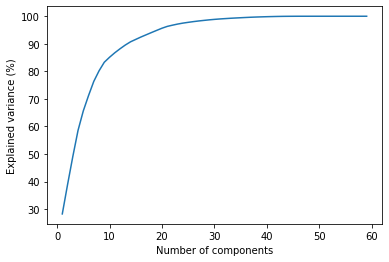

In [45]:
# Assign X & y
X = train_df.iloc[:, :59].values
y = train_df.iloc[:, 59].values
X_predict = df.values

components = None
pca = PCA(n_components = components)# perform PCA on the scaled data
pca.fit(X)

# print the explained variances
print("Variances (Percentage):")
print(pca.explained_variance_ratio_ * 100)
print()

print("Cumulative Variances (Percentage):")
print(pca.explained_variance_ratio_.cumsum() * 100)
print()

# plot a scree plot
components = len(pca.explained_variance_ratio_) \
    if components is None else components

plt.plot(range(1,components+1), 
         np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Number of components")
plt.ylabel("Explained variance (%)")

PCA(n_components=0.85)

Cumulative Variances (Percentage):
[28.27665031 38.87420145 49.04831054 58.5834654  65.6366365  71.20799062
 76.35784467 80.17989751 83.3012492  85.11050812]
Number of components: 10


Text(0.5, 0, 'Number of components')

Text(0, 0.5, 'Explained variance (%)')

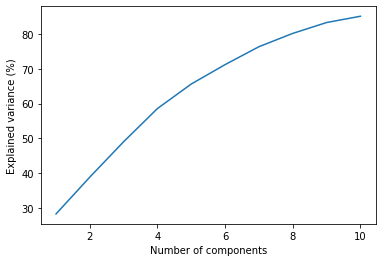

In [46]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 0.85)
pca.fit(X)

print("Cumulative Variances (Percentage):")
print(np.cumsum(pca.explained_variance_ratio_ * 100))

components = len(pca.explained_variance_ratio_)
print(f'Number of components: {components}')

# Make the scree plot
plt.plot(range(1, components + 1), np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Number of components")
plt.ylabel("Explained variance (%)")

In [48]:
pca_components = abs(pca.components_)
print(pca_components)
pca_df = pd.DataFrame(pca_components, index=['component 1', 'component 2',
                            'component 3', 'component 4', 'component 5', 'component 6',
                            'component 7', 'component 8', 'component 9', 'component 10'], 
                        columns=[train_df.columns.tolist()[:59]])
pca_df

[[2.87227343e-01 8.96096930e-02 8.97219576e-02 6.74473986e-03
  4.13430282e-03 2.07266735e-01 2.17862327e-01 6.85740594e-02
  2.76914449e-02 2.13251641e-01 4.27787785e-01 4.21828521e-01
  4.27409030e-01 4.21559491e-01 1.48317983e-01 2.31623966e-03
  1.38331441e-02 1.11976999e-03 1.04687299e-03 7.98916117e-04
  7.23900984e-04 3.06764876e-05 6.24904989e-04 6.53463338e-04
  6.29446514e-03 1.24659870e-02 5.00597891e-03 2.56297516e-02
  3.69855105e-03 3.22320242e-03 3.63391886e-03 4.03750453e-03
  1.43336467e-02 2.74105030e-02 1.35596777e-02 6.25744476e-02
  2.58982894e-03 4.94612460e-03 5.00597891e-03 3.99507443e-03
  5.36749103e-03 6.73342876e-02 4.21115101e-04 1.02614828e-02
  3.69855105e-03 3.22320242e-03 5.07349572e-03 3.21280376e-03
  1.74445284e-02 4.03750453e-03 1.88659097e-02 4.36667027e-02
  7.87018168e-03 7.46703468e-03 4.11263753e-02 2.74105030e-02
  1.39347505e-02 1.71650842e-02 6.10785082e-03]
 [1.26111696e-01 2.10861883e-02 4.77514367e-02 7.50131986e-02
  5.06900714e-02 2.654

,mkt_carrier_fl_num,origin,dest,crs_dep_time,crs_arr_time,crs_elapsed_time,distance,speed_passengers,mean_passengers,sum_passengers,...,op_unique_carrier_NK,op_unique_carrier_OH,op_unique_carrier_OO,op_unique_carrier_PT,op_unique_carrier_QX,op_unique_carrier_UA,op_unique_carrier_WN,op_unique_carrier_YV,op_unique_carrier_YX,op_unique_carrier_ZW
component 1,0.287227,0.089610,0.089722,0.006745,0.004134,0.207267,0.217862,0.068574,0.027691,0.213252,...,0.004038,0.018866,0.043667,0.007870,0.007467,0.041126,0.027411,0.013935,0.017165,0.006108
component 2,0.126112,0.021086,0.047751,0.075013,0.050690,0.265419,0.258172,0.064127,0.626401,0.566816,...,0.009752,0.003047,0.022150,0.001522,0.000936,0.005041,0.033728,0.001109,0.001301,0.000238
component 3,0.015613,0.316975,0.333123,0.620567,0.609174,0.019931,0.001217,0.132442,0.081436,0.060156,...,0.000224,0.000987,0.002557,0.001460,0.001125,0.005642,0.000380,0.001134,0.000009,0.001060
component 4,0.070826,0.020934,0.021320,0.018580,0.044184,0.588168,0.584792,0.126926,0.309876,0.149538,...,0.014621,0.005101,0.009577,0.004713,0.002478,0.013653,0.042144,0.001111,0.007048,0.001942
component 5,0.070257,0.482068,0.579146,0.311707,0.344815,0.067546,0.040678,0.440620,0.009184,0.015915,...,0.002631,0.004255,0.006823,0.004719,0.001984,0.017066,0.012992,0.005568,0.000244,0.001145
component 6,0.198539,0.518035,0.072733,0.082826,0.102599,0.130094,0.116631,0.651241,0.012499,0.043848,...,0.011075,0.013281,0.003095,0.007105,0.000804,0.015504,0.028075,0.017140,0.003195,0.005234
component 7,0.130346,0.037651,0.243181,0.003908,0.002589,0.057758,0.051117,0.401836,0.035476,0.020406,...,0.003815,0.015047,0.020555,0.012276,0.011749,0.064673,0.075888,0.005376,0.008967,0.000064
component 8,0.631687,0.327530,0.432893,0.029238,0.055503,0.078642,0.018550,0.304763,0.050762,0.054805,...,0.021155,0.024060,0.075792,0.001461,0.025660,0.034369,0.167109,0.025044,0.029660,0.004010
component 9,0.578339,0.428041,0.430418,0.043673,0.007716,0.115650,0.137509,0.035604,0.155236,0.115617,...,0.052193,0.010008,0.034386,0.000718,0.019505,0.002200,0.219049,0.024736,0.000087,0.008394
component 10,0.125723,0.220812,0.184691,0.047630,0.057335,0.002033,0.013582,0.139383,0.240415,0.294820,...,0.019343,0.077871,0.096332,0.031914,0.004061,0.003878,0.276438,0.031097,0.025370,0.007030


#### __StandardScale Testing Dataset__

In [49]:
df_columns = df.columns.tolist()
df_columns

['mkt_carrier_fl_num',
 'origin',
 'dest',
 'crs_dep_time',
 'crs_arr_time',
 'crs_elapsed_time',
 'distance',
 'speed_passengers',
 'mean_passengers',
 'sum_passengers',
 'total_cost:mean_fuel',
 'total_cost:sum_fuel',
 'total_gallons:mean_fuel',
 'total_gallons:sum_fuel',
 'avg_arr_delay',
 'year_2020',
 'month_1',
 'day_of_week_0',
 'day_of_week_1',
 'day_of_week_2',
 'day_of_week_3',
 'day_of_week_4',
 'day_of_week_5',
 'day_of_week_6',
 'mkt_unique_carrier_AA',
 'mkt_unique_carrier_AS',
 'mkt_unique_carrier_B6',
 'mkt_unique_carrier_DL',
 'mkt_unique_carrier_F9',
 'mkt_unique_carrier_G4',
 'mkt_unique_carrier_HA',
 'mkt_unique_carrier_NK',
 'mkt_unique_carrier_UA',
 'mkt_unique_carrier_WN',
 'op_unique_carrier_9E',
 'op_unique_carrier_AA',
 'op_unique_carrier_AS',
 'op_unique_carrier_AX',
 'op_unique_carrier_B6',
 'op_unique_carrier_C5',
 'op_unique_carrier_CP',
 'op_unique_carrier_DL',
 'op_unique_carrier_EM',
 'op_unique_carrier_EV',
 'op_unique_carrier_F9',
 'op_unique_carrier_

In [50]:
# start time to measure the time of the program execution
start_time = time.time()

# get the numerical features & review their stats
feature_names_num1 = ['mkt_carrier_fl_num', 'origin', 'dest', 
                     'crs_dep_time', 'crs_arr_time',
                     'crs_elapsed_time', 'distance', 'avg_arr_delay',
                     'speed_passengers', 
                    'mean_passengers', 'sum_passengers',
                    'total_cost:mean_fuel', 'total_cost:sum_fuel',
                    'total_gallons:mean_fuel', 'total_gallons:sum_fuel']

var_scale1 = df[feature_names_num1]
var_scale1.describe()

# standard scale the numerical variables & make them into pd.dataframe
scaler = StandardScaler()
df_scale1 = pd.DataFrame(scaler.fit_transform(var_scale1), columns = feature_names_num1)
df_scale1

# replace the numerical variables with the scaled variables
df2 = df.drop(feature_names_num1, axis=1)

# combine dummy variables with work_df
df = pd.concat([df2, df_scale1], axis=1)

# rearrange the columns in work_df3
df = df[df_columns]
df.info()
df.head()

# check
len(df.columns)
df.columns.tolist()

# print the overall program runtime.
print(f"\n\n--- {(time.time() - start_time)} seconds ---")

,mkt_carrier_fl_num,origin,dest,crs_dep_time,crs_arr_time,crs_elapsed_time,distance,avg_arr_delay,speed_passengers,mean_passengers,sum_passengers,total_cost:mean_fuel,total_cost:sum_fuel,total_gallons:mean_fuel,total_gallons:sum_fuel
count,660556.000000,660556.000000,660556.000000,660556.000000,660556.000000,660556.000000,660556.000000,660556.000000,660556.000000,660556.0,660556.000000,6.605560e+05,6.605560e+05,6.605560e+05,6.605560e+05
mean,2758.732107,11783.324960,11786.769434,1330.097584,1491.814630,140.918700,765.531673,1.871759,0.291700,1.0,9820.024314,2.045052e+08,1.022338e+09,1.137455e+08,5.686155e+08
std,1839.125706,9497.440782,9500.832297,486.239023,513.549707,71.570367,579.020673,23.567251,0.257692,0.0,6490.190446,2.018209e+08,1.009290e+09,1.130116e+08,5.651673e+08
min,1.000000,9.000000,9.000000,2.000000,1.000000,-77.000000,31.000000,-38.142857,0.036056,1.0,439.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1161.000000,3923.000000,3922.000000,920.000000,1109.000000,90.000000,342.000000,-3.510152,0.185793,1.0,3596.000000,7.937670e+06,3.968835e+07,5.327632e+06,2.663816e+07
50%,2358.000000,10312.000000,10302.000000,1325.000000,1519.000000,122.000000,605.000000,1.126154,0.247594,1.0,10347.000000,1.141528e+08,5.707640e+08,6.360548e+07,3.180274e+08
75%,4396.000000,15534.000000,15541.000000,1732.000000,1920.000000,171.000000,1009.000000,7.666667,0.341570,1.0,15744.000000,4.295422e+08,2.147711e+09,2.534325e+08,1.267163e+09
max,9336.000000,32201.000000,32197.000000,2359.000000,2400.000000,700.000000,5095.000000,1366.000000,8.811448,1.0,20704.000000,5.077168e+08,2.538584e+09,2.669605e+08,1.334803e+09


,mkt_carrier_fl_num,origin,dest,crs_dep_time,crs_arr_time,crs_elapsed_time,distance,avg_arr_delay,speed_passengers,mean_passengers,sum_passengers,total_cost:mean_fuel,total_cost:sum_fuel,total_gallons:mean_fuel,total_gallons:sum_fuel
0,1.701499,-1.031892,0.229162,0.986969,0.882457,-0.641589,-0.695194,-1.697892,-0.457355,0.0,0.912759,0.456728,0.456831,0.391009,0.391132
1,1.912469,-1.031892,0.229162,-0.370389,-0.334563,-0.711450,-0.695194,-1.697892,-0.457355,0.0,0.912759,0.456728,0.456831,0.391009,0.391132
2,1.000078,-1.031892,-0.641604,1.418856,1.242695,-0.990895,-0.747006,-0.099269,-0.444578,0.0,0.912759,0.456728,0.456831,0.391009,0.391132
3,1.088707,-1.031892,-0.641604,0.020365,-0.071687,-0.921034,-0.747006,-0.099269,-0.444578,0.0,0.912759,0.456728,0.456831,0.391009,0.391132
4,1.306746,-1.031892,-0.641604,-0.853691,-0.889524,-0.851173,-0.747006,-0.099269,-0.444578,0.0,0.912759,0.456728,0.456831,0.391009,0.391132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660551,1.193648,0.030816,-0.821589,1.087742,1.069392,-0.543783,-0.612296,0.548491,-0.242580,0.0,-0.948667,-1.013301,-1.012928,-1.006495,-1.006102
660552,1.194192,0.030816,-0.821589,0.380271,0.409280,-0.473921,-0.612296,0.548491,-0.242580,0.0,-0.948667,-1.013301,-1.012928,-1.006495,-1.006102
660553,1.194736,-0.154918,-1.149981,1.799327,1.645773,-0.683505,-0.862719,0.725293,-0.143117,0.0,-0.948667,-1.013301,-1.012928,-1.006495,-1.006102
660554,1.195280,2.061786,-0.156278,-0.606899,-0.264463,0.001136,-0.044095,0.166918,-0.398312,0.0,-0.948667,-1.013301,-1.012928,-1.006495,-1.006102


<class 'pandas.core.frame.DataFrame'>
Int64Index: 660556 entries, 0 to 660555
Data columns (total 59 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   mkt_carrier_fl_num       660556 non-null  float64
 1   origin                   660556 non-null  float64
 2   dest                     660556 non-null  float64
 3   crs_dep_time             660556 non-null  float64
 4   crs_arr_time             660556 non-null  float64
 5   crs_elapsed_time         660556 non-null  float64
 6   distance                 660556 non-null  float64
 7   speed_passengers         660556 non-null  float64
 8   mean_passengers          660556 non-null  float64
 9   sum_passengers           660556 non-null  float64
 10  total_cost:mean_fuel     660556 non-null  float64
 11  total_cost:sum_fuel      660556 non-null  float64
 12  total_gallons:mean_fuel  660556 non-null  float64
 13  total_gallons:sum_fuel   660556 non-null  float64
 14  avg_

,mkt_carrier_fl_num,origin,dest,crs_dep_time,crs_arr_time,crs_elapsed_time,distance,speed_passengers,mean_passengers,sum_passengers,...,op_unique_carrier_NK,op_unique_carrier_OH,op_unique_carrier_OO,op_unique_carrier_PT,op_unique_carrier_QX,op_unique_carrier_UA,op_unique_carrier_WN,op_unique_carrier_YV,op_unique_carrier_YX,op_unique_carrier_ZW
0,1.701499,-1.031892,0.229162,0.986969,0.882457,-0.641589,-0.695194,-0.457355,0.0,0.912759,...,0,0,0,0,0,0,1,0,0,0
1,1.912469,-1.031892,0.229162,-0.370389,-0.334563,-0.711450,-0.695194,-0.457355,0.0,0.912759,...,0,0,0,0,0,0,1,0,0,0
2,1.000078,-1.031892,-0.641604,1.418856,1.242695,-0.990895,-0.747006,-0.444578,0.0,0.912759,...,0,0,0,0,0,0,1,0,0,0
3,1.088707,-1.031892,-0.641604,0.020365,-0.071687,-0.921034,-0.747006,-0.444578,0.0,0.912759,...,0,0,0,0,0,0,1,0,0,0
4,1.306746,-1.031892,-0.641604,-0.853691,-0.889524,-0.851173,-0.747006,-0.444578,0.0,0.912759,...,0,0,0,0,0,0,1,0,0,0


59

['mkt_carrier_fl_num',
 'origin',
 'dest',
 'crs_dep_time',
 'crs_arr_time',
 'crs_elapsed_time',
 'distance',
 'speed_passengers',
 'mean_passengers',
 'sum_passengers',
 'total_cost:mean_fuel',
 'total_cost:sum_fuel',
 'total_gallons:mean_fuel',
 'total_gallons:sum_fuel',
 'avg_arr_delay',
 'year_2020',
 'month_1',
 'day_of_week_0',
 'day_of_week_1',
 'day_of_week_2',
 'day_of_week_3',
 'day_of_week_4',
 'day_of_week_5',
 'day_of_week_6',
 'mkt_unique_carrier_AA',
 'mkt_unique_carrier_AS',
 'mkt_unique_carrier_B6',
 'mkt_unique_carrier_DL',
 'mkt_unique_carrier_F9',
 'mkt_unique_carrier_G4',
 'mkt_unique_carrier_HA',
 'mkt_unique_carrier_NK',
 'mkt_unique_carrier_UA',
 'mkt_unique_carrier_WN',
 'op_unique_carrier_9E',
 'op_unique_carrier_AA',
 'op_unique_carrier_AS',
 'op_unique_carrier_AX',
 'op_unique_carrier_B6',
 'op_unique_carrier_C5',
 'op_unique_carrier_CP',
 'op_unique_carrier_DL',
 'op_unique_carrier_EM',
 'op_unique_carrier_EV',
 'op_unique_carrier_F9',
 'op_unique_carrier_



--- 1.29010009765625 seconds ---


In [51]:
from sklearn.pipeline import Pipeline

#_sc = StandardScaler()
_pca = PCA(n_components = 11)

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [52]:
# start time to measure the time of the program execution
start_time = time.time()

# Fit Model
_model7 = XGBRegressor(subsample=0.6, n_estimators=500, max_depth=3, 
                       learning_rate=0.01, colsample_bytree=0.4, colsample_bylevel=0.6)
xgb = Pipeline([
    ('pca', _pca),
    ('regressor', _model7)
])
#xgb = XGBRegressor()
xgb.fit(X_train, y_train)
y_predict = xgb.predict(X_predict)

# print the overall program runtime.
print(f"\n\n--- {(time.time() - start_time)} seconds ---")

Pipeline(steps=[('pca', PCA(n_components=11)),
                ('regressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=0.6, colsample_bynode=1,
                              colsample_bytree=0.4, enable_categorical=False,
                              gamma=0, gpu_id=-1, importance_type=None,
                              interaction_constraints='', learning_rate=0.01,
                              max_delta_step=0, max_depth=3, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=500, n_jobs=8, num_parallel_tree=1,
                              predictor='auto', random_state=0, reg_alpha=0,
                              reg_lambda=1, scale_pos_weight=1, subsample=0.6,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])



--- 21.31219458580017 seconds ---


In [39]:
#params = { 'max_depth': [3, 5, 6, 10, 15, 20],
#           'learning_rate': [0.01, 0.1, 0.2, 0.3],
#           'subsample': np.arange(0.5, 1.0, 0.1),
#           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
#           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
#           'n_estimators': [50, 100, 500]}

In [53]:
len(y_predict)

660556

In [54]:
df_submission_col['predicted_delay'] = y_predict

df_submission_col.info()
df_submission_col.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660556 entries, 0 to 660555
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   fl_date             660556 non-null  object 
 1   mkt_carrier         660556 non-null  object 
 2   mkt_carrier_fl_num  660556 non-null  int64  
 3   origin              660556 non-null  object 
 4   dest                660556 non-null  object 
 5   predicted_delay     660556 non-null  float32
dtypes: float32(1), int64(1), object(4)
memory usage: 27.7+ MB


,fl_date,mkt_carrier,mkt_carrier_fl_num,origin,dest,predicted_delay
0,2020-01-01,WN,5888,ONT,SFO,3.644577
1,2020-01-01,WN,6276,ONT,SFO,3.644577
2,2020-01-01,WN,4598,ONT,SJC,3.644577
3,2020-01-01,WN,4761,ONT,SJC,3.644577
4,2020-01-01,WN,5162,ONT,SJC,3.644577


In [55]:
df_submission_col.to_csv('submission_NicoleHong.csv', index=False)